In [2]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download jangedoo/utkface-new

100% 330M/331M [00:16<00:00, 20.9MB/s]
100% 331M/331M [00:16<00:00, 21.4MB/s]


In [3]:
import os
! unzip utkface-new

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [4]:
import os
import shutil
import random
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import keras
from os import listdir
from os.path import isdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
import tensorflow as tf
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from keras.layers import Input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, ReLU, BatchNormalization, Conv2D,  MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
utkface_path = '/content/UTKFace/'  
trial_path = '/content/Trial/'

if not os.path.exists(trial_path):
    os.mkdir(trial_path)

genders = [0, 1]
max_num_files = 25

for age in range(1, 80):
    for gender in genders:
        age_gender_files = [f for f in os.listdir(utkface_path) if f.startswith(f"{age}_{gender}_")]
        num_files = len(age_gender_files)
        if num_files < max_num_files:
            num_to_augment = max_num_files - num_files
            for i in range(num_to_augment):
                # Randomly select an existing image
                source_file = random.choice(age_gender_files)
                source_path = os.path.join(utkface_path, source_file)
                dest_file = f"{age}_{gender}_{num_files+i}.jpg"
                dest_path = os.path.join(trial_path, dest_file)
                
                # Apply image augmentation
                img = Image.open(source_path)
                enhancer = ImageEnhance.Brightness(img)
                img = enhancer.enhance(0.5)
                enhancer = ImageEnhance.Contrast(img)
                img = enhancer.enhance(0.5)
                img.save(dest_path)
                
        elif num_files >= max_num_files:
            num_files = max_num_files
            
        for i in range(num_files):
            source_file = age_gender_files[i]
            source_path = os.path.join(utkface_path, source_file)
            dest_path = os.path.join(trial_path, source_file)
            shutil.copy(source_path, dest_path)


In [6]:
files = os.listdir(trial_path)
size = len(files)
size_genders = len(genders)
print("Total samples:",size)

Total samples: 3950


In [29]:
ages = []
genders = []
sorted_img = []

for file in files:
    image = cv2.imread(trial_path + file,1) #,0 for convert the image into gray scale 1 for colour channel
    image = cv2.resize(image,dsize=(224,224))
    image = image.reshape((image.shape[0],image.shape[1],3))
    sorted_img.append(image)
    split_age_gender = file.split('_')
    ages.append(split_age_gender[0])
    genders.append(int(split_age_gender[1]))

In [30]:
color_img = []

for file in files:
    image = cv2.imread(trial_path + file, 1) # 1 for color image
    image = cv2.resize(image, dsize=(224, 224))
    color_img.append(image)


In [31]:
len(sorted_img)

3950

In [32]:
len(color_img)

3950

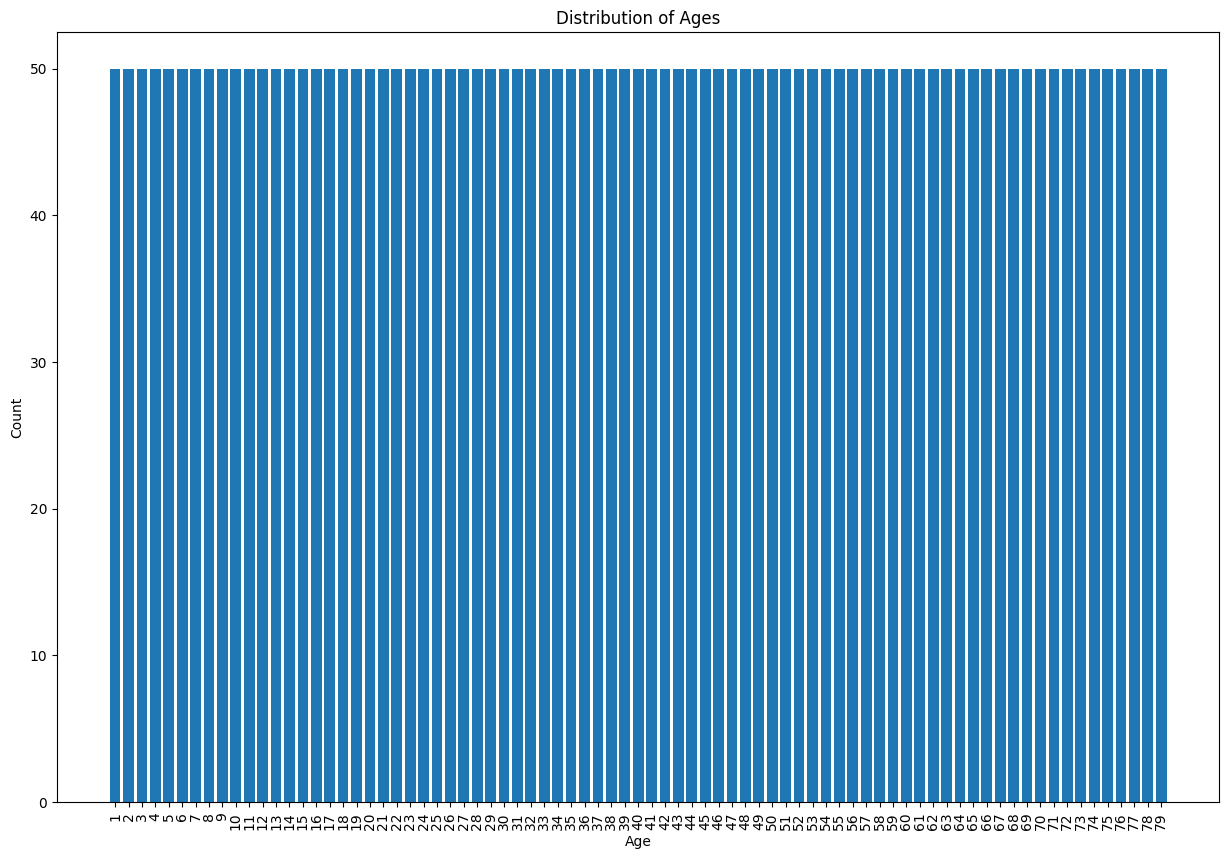

Maximum age: 79


In [33]:
distribution_list = list(set(ages))
distribution_list_int = [int(s) for s in distribution_list]
distribution_list_sorted = sorted(distribution_list_int)


ages_sorted = [str(i).zfill(1) for i in distribution_list_sorted]

x_ages = list(set(ages_sorted))
x_ages = sorted(x_ages)
y_ages = [ages.count(i) for i in x_ages]

plt.figure(figsize=(15, 10)) # set the size of the figure
plt.bar(ages_sorted, y_ages)

plt.xticks(rotation=90) # rotate the x-axis labels by 90 degrees
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')

plt.show()

max_age = max(map(int, x_ages))
print("Maximum age:", max_age)


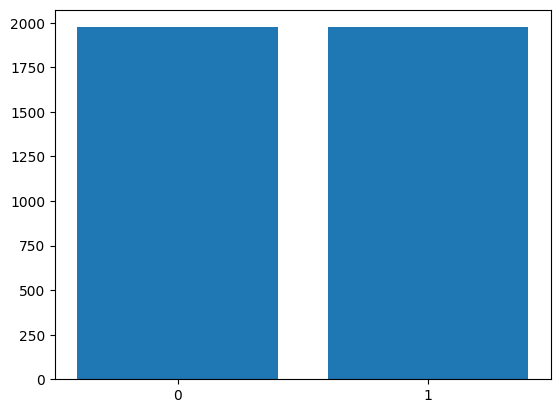

Max value: 1


In [34]:
x_genders = list(set(genders))
y_genders = [genders.count(i) for i in x_genders]

gender_labels = ['0', '1']
plt.bar(gender_labels, y_genders)

plt.show()
print("Max value:",max(genders))


In [35]:
id_img = 14
sample = sorted_img[id_img]

In [37]:
labels = np.zeros((len(ages), 2), dtype='float32') # 2 เพื่อเก็บค่าสองค่า แบบ labels[1,2]
features = np.zeros((len(ages),sample.shape[0],sample.shape[1],3),dtype = 'float32')
for i in range (len(files)):
    labels[i,0] = int(ages[i])
    labels[i,1] = int(genders[i])
    features[i] = sorted_img[i]

In [38]:
print(labels.shape)
print(features.shape)

(3950, 2)
(3950, 224, 224, 3)


In [39]:
features = features / 255 #normalization

In [40]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle = True)

In [41]:
for i in range (50):
    print(y_train[i])

[30.  0.]
[58.  1.]
[37.  0.]
[63.  0.]
[61.  1.]
[71.  0.]
[75.  1.]
[62.  1.]
[55.  1.]
[26.  0.]
[76.  1.]
[8. 1.]
[27.  1.]
[42.  1.]
[9. 1.]
[73.  1.]
[49.  1.]
[58.  0.]
[58.  0.]
[77.  0.]
[32.  1.]
[26.  0.]
[33.  0.]
[4. 1.]
[38.  0.]
[48.  1.]
[65.  1.]
[14.  1.]
[49.  0.]
[6. 0.]
[24.  1.]
[66.  1.]
[49.  0.]
[4. 0.]
[37.  1.]
[7. 0.]
[67.  0.]
[57.  1.]
[29.  1.]
[8. 0.]
[54.  1.]
[7. 0.]
[63.  1.]
[51.  0.]
[61.  0.]
[56.  1.]
[23.  1.]
[50.  0.]
[38.  1.]
[73.  0.]


In [42]:
print("Shape of the images:",sample.shape)
print("Training images numbers:",x_train.shape[0])
print("Testing images numbers:",x_test.shape[0])

Shape of the images: (224, 224, 3)
Training images numbers: 3160
Testing images numbers: 790


In [43]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                                         include_top=False,
                                         input_shape=(224, 224, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape=(224, 224,3))

#age

age_model = Flatten()(base_model.output)
age_model = Dense(128, activation='relu')(age_model)
age_model = Dropout(0.5)(age_model)
age_model = Dense(64, activation='relu')(age_model)
age_model = Dropout(0.5)(age_model)
age_model = BatchNormalization()(age_model)
age_model = Dense(1,activation = 'relu')(age_model)

#gender
gender_model = base_model.output
gender_model = tf.keras.layers.Flatten()(gender_model)
gender_model = Dense(256, activation='relu')(gender_model)
gender_model = Dropout(0.5)(gender_model)
gender_model = Dense(128, activation='relu')(gender_model)
gender_model = Dropout(0.5)(gender_model)
gender_model = Dense(1, activation='sigmoid')(gender_model)

model = Model(inputs=base_model.input, outputs=[age_model,gender_model])
model.compile(optimizer = 'adam', loss =['mse','binary_crossentropy'],metrics=['mae','accuracy'])

In [45]:
history = model.fit(x_train,[y_train[:,0],y_train[:,1]],validation_data=(x_test,[y_test[:,0],y_test[:,1]]),
              epochs = 100, batch_size = 128, shuffle = True)

Epoch 1/100
25/25 [==============================] - 45s 1s/step - loss: 2062.9602 - dense_21_loss: 2061.9399 - dense_24_loss: 1.0207 - dense_21_mae: 39.4048 - dense_21_accuracy: 0.0041 - dense_24_mae: 0.4377 - dense_24_accuracy: 0.5753 - val_loss: 2070.1379 - val_dense_21_loss: 2069.5930 - val_dense_24_loss: 0.5451 - val_dense_21_mae: 39.1823 - val_dense_21_accuracy: 0.0000e+00 - val_dense_24_mae: 0.3967 - val_dense_24_accuracy: 0.7354
Epoch 2/100
25/25 [==============================] - 17s 674ms/step - loss: 1974.8740 - dense_21_loss: 1974.3647 - dense_24_loss: 0.5093 - dense_21_mae: 38.4835 - dense_21_accuracy: 0.0054 - dense_24_mae: 0.3451 - dense_24_accuracy: 0.7459 - val_loss: 1791.5214 - val_dense_21_loss: 1791.0693 - val_dense_24_loss: 0.4520 - val_dense_21_mae: 36.1791 - val_dense_21_accuracy: 0.0025 - val_dense_24_mae: 0.3140 - val_dense_24_accuracy: 0.7684
Epoch 3/100
25/25 [==============================] - 17s 667ms/step - loss: 1816.5413 - dense_21_loss: 1816.0848 - dens

In [46]:
model.save('combine_Pretrained.h5')
history_test = history
print(history_test.history.keys())



dict_keys(['loss', 'dense_21_loss', 'dense_24_loss', 'dense_21_mae', 'dense_21_accuracy', 'dense_24_mae', 'dense_24_accuracy', 'val_loss', 'val_dense_21_loss', 'val_dense_24_loss', 'val_dense_21_mae', 'val_dense_21_accuracy', 'val_dense_24_mae', 'val_dense_24_accuracy'])


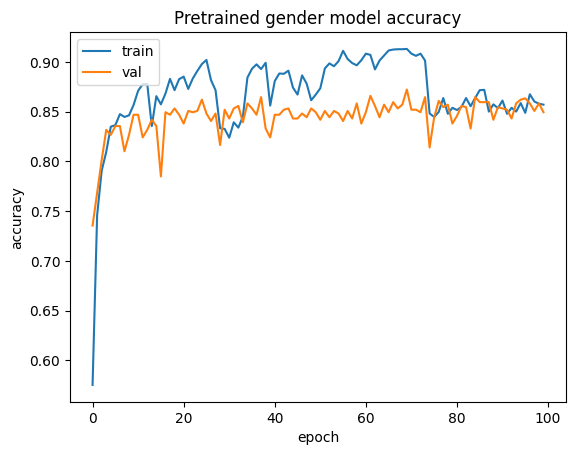

val accuracy: 84.48%


In [47]:
plt.plot(history_test.history['dense_24_accuracy'])
plt.plot(history_test.history['val_dense_24_accuracy'])
plt.title('Pretrained gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

val_acc = np.mean(history_test.history['val_dense_24_accuracy'])
print("%s: %.2f%%" % ('val accuracy',(val_acc*100)))

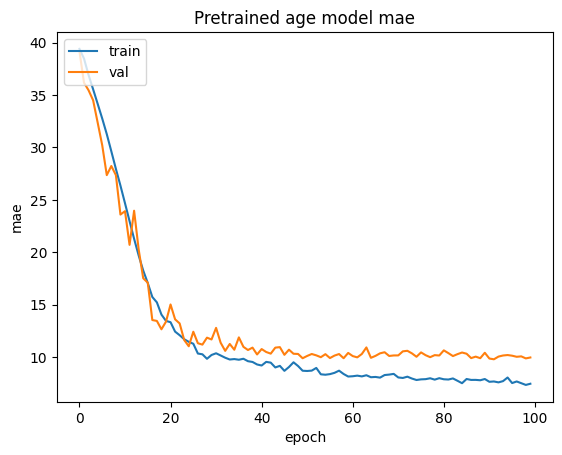

val mae: 13.39%


In [48]:
plt.plot(history_test.history['dense_21_mae'])
plt.plot(history_test.history['val_dense_21_mae'])
plt.title('Pretrained age model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

val_mae = np.mean(history_test.history['val_dense_21_mae'])
print("%s: %.2f%%" %("val mae", val_mae))

In [49]:
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

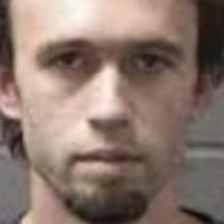

Actual Gender: Male Age: 28
1/1 [==============================] - 1s 778ms/step
Predicted Gender: Male Predicted Age: [[32.459984]]


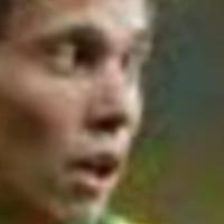

Actual Gender: Male Age: 23
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[29.223469]]


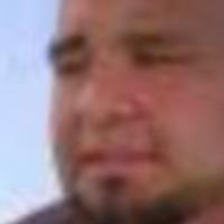

Actual Gender: Male Age: 26
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[30.828842]]


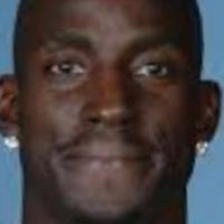

Actual Gender: Male Age: 29
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male Predicted Age: [[32.459984]]


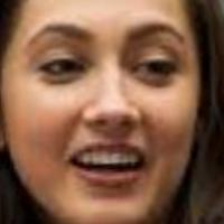

Actual Gender: Female Age: 27
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[32.997154]]


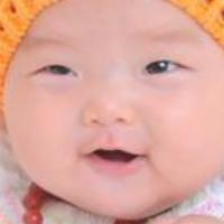

Actual Gender: Female Age: 1
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[0.]]


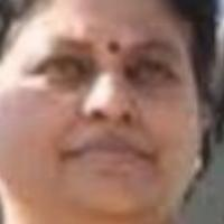

Actual Gender: Female Age: 54
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Female Predicted Age: [[53.095375]]


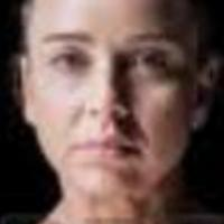

Actual Gender: Female Age: 29
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Female Predicted Age: [[32.459984]]


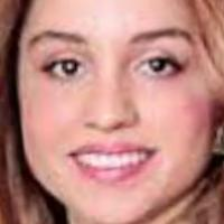

Actual Gender: Female Age: 18
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[31.44371]]


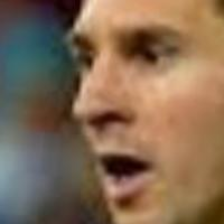

Actual Gender: Male Age: 27
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[31.440117]]


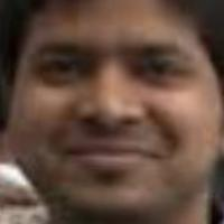

Actual Gender: Male Age: 35
1/1 [==============================] - 0s 31ms/step
Predicted Gender: Male Predicted Age: [[43.823257]]


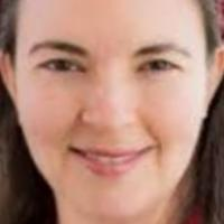

Actual Gender: Female Age: 36
1/1 [==============================] - 0s 25ms/step
Predicted Gender: Female Predicted Age: [[20.751808]]


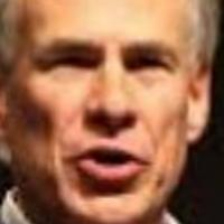

Actual Gender: Male Age: 50
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male Predicted Age: [[52.096897]]


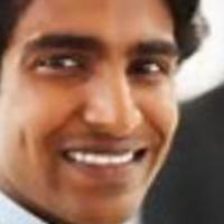

Actual Gender: Male Age: 25
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male Predicted Age: [[32.459984]]


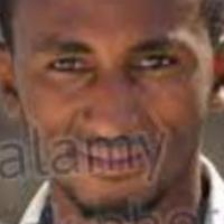

Actual Gender: Male Age: 29
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[31.715431]]


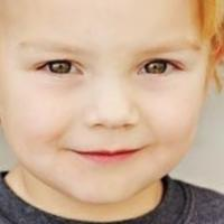

Actual Gender: Male Age: 2
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[0.]]


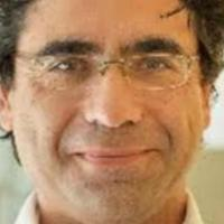

Actual Gender: Male Age: 52
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male Predicted Age: [[51.87572]]


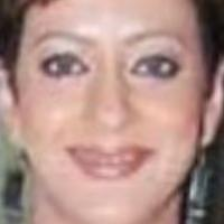

Actual Gender: Female Age: 45
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[32.459984]]


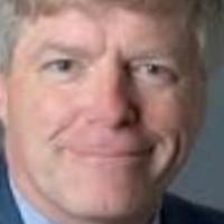

Actual Gender: Male Age: 61
1/1 [==============================] - 0s 24ms/step
Predicted Gender: Male Predicted Age: [[56.68728]]


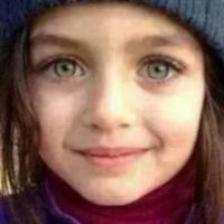

Actual Gender: Female Age: 8
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female Predicted Age: [[2.8393955]]


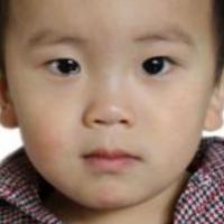

Actual Gender: Male Age: 4
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male Predicted Age: [[0.]]


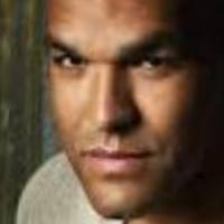

Actual Gender: Male Age: 25
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male Predicted Age: [[32.459984]]


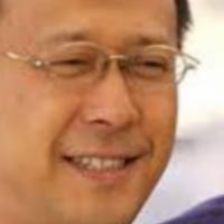

Actual Gender: Male Age: 40
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[35.113316]]


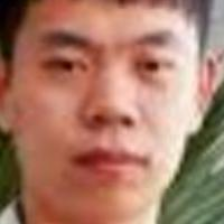

Actual Gender: Male Age: 32
1/1 [==============================] - 0s 34ms/step
Predicted Gender: Male Predicted Age: [[32.459984]]


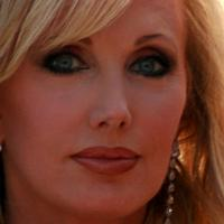

Actual Gender: Female Age: 54
1/1 [==============================] - 0s 26ms/step
Predicted Gender: Female Predicted Age: [[53.855988]]


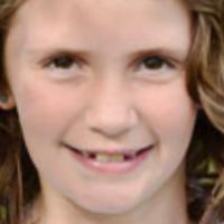

Actual Gender: Female Age: 8
1/1 [==============================] - 0s 30ms/step
Predicted Gender: Female Predicted Age: [[7.226432]]


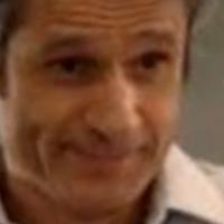

Actual Gender: Male Age: 38
1/1 [==============================] - 0s 32ms/step
Predicted Gender: Male Predicted Age: [[56.13728]]


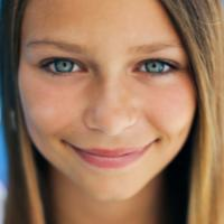

Actual Gender: Female Age: 16
1/1 [==============================] - 0s 43ms/step
Predicted Gender: Female Predicted Age: [[16.142017]]


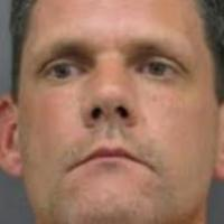

Actual Gender: Male Age: 48
1/1 [==============================] - 0s 47ms/step
Predicted Gender: Male Predicted Age: [[46.449356]]


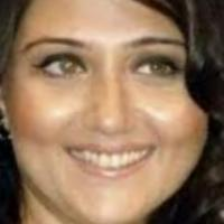

Actual Gender: Female Age: 26
1/1 [==============================] - 0s 58ms/step
Predicted Gender: Female Predicted Age: [[32.342594]]


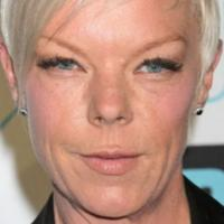

Actual Gender: Female Age: 60
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[50.28274]]


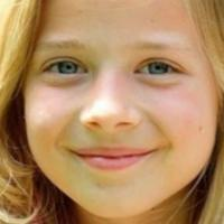

Actual Gender: Female Age: 10
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[0.]]


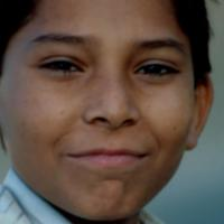

Actual Gender: Male Age: 9
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male Predicted Age: [[8.217304]]


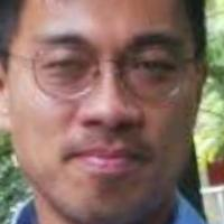

Actual Gender: Male Age: 41
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[44.177635]]


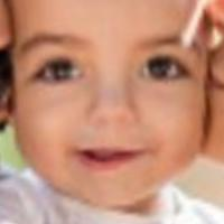

Actual Gender: Female Age: 1
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[0.]]


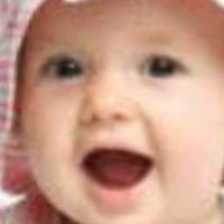

Actual Gender: Female Age: 1
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[0.]]


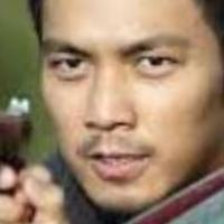

Actual Gender: Male Age: 37
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[32.459984]]


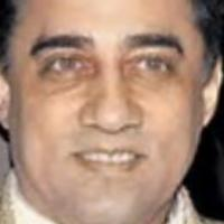

Actual Gender: Male Age: 56
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Male Predicted Age: [[46.87738]]


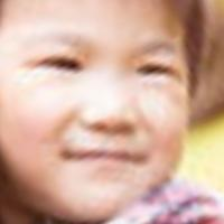

Actual Gender: Male Age: 4
1/1 [==============================] - 0s 25ms/step
Predicted Gender: Female Predicted Age: [[13.13593]]


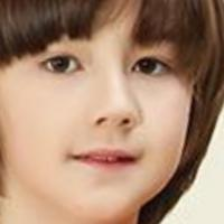

Actual Gender: Male Age: 12
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[1.456206]]


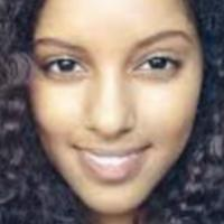

Actual Gender: Female Age: 26
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Female Predicted Age: [[32.459984]]


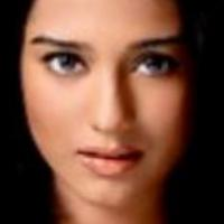

Actual Gender: Female Age: 20
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Female Predicted Age: [[32.459984]]


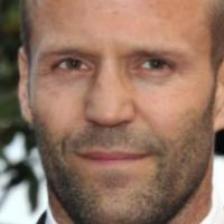

Actual Gender: Male Age: 47
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male Predicted Age: [[49.215992]]


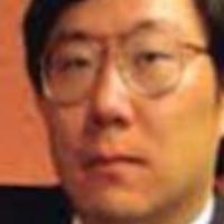

Actual Gender: Male Age: 38
1/1 [==============================] - 0s 27ms/step
Predicted Gender: Male Predicted Age: [[46.60343]]


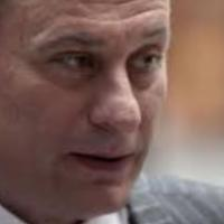

Actual Gender: Male Age: 52
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Male Predicted Age: [[55.654198]]


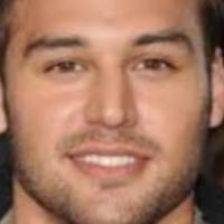

Actual Gender: Male Age: 24
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[32.37407]]


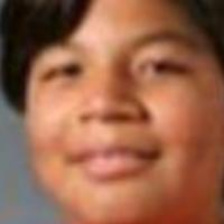

Actual Gender: Male Age: 14
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Female Predicted Age: [[35.485886]]


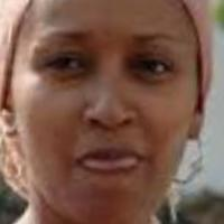

Actual Gender: Female Age: 38
1/1 [==============================] - 0s 22ms/step
Predicted Gender: Female Predicted Age: [[32.11742]]


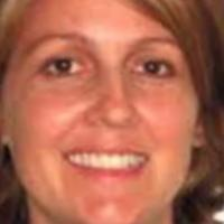

Actual Gender: Female Age: 39
1/1 [==============================] - 0s 23ms/step
Predicted Gender: Female Predicted Age: [[48.957077]]


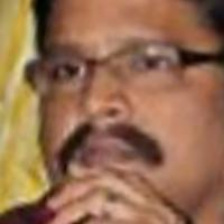

Actual Gender: Male Age: 35
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male Predicted Age: [[35.048737]]


In [50]:
def get_result(sample):
    sample = sample/255
    val = model.predict( np.array([ sample ]) )    
    age = val[0]
    gender = get_gender(val[1])
    print("Predicted Gender:",gender,"Predicted Age:",age)
for i in range (50): 
    indexes = [i]
    for idx in indexes:
        sample = sorted_img[idx]
        cv2_imshow(color_img[idx])
        print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
        res = get_result(sample)

In [51]:
predict = model.predict(x_test)

25/25 [==============================] - 8s 127ms/step


In [52]:
print(predict)

[array([[32.459984  ],
       [31.98891   ],
       [32.459984  ],
       [53.144493  ],
       [63.143204  ],
       [40.854973  ],
       [65.56785   ],
       [56.455536  ],
       [32.459984  ],
       [54.13216   ],
       [50.897743  ],
       [26.752342  ],
       [41.838196  ],
       [32.459984  ],
       [17.54343   ],
       [48.83281   ],
       [19.093704  ],
       [ 0.        ],
       [56.57792   ],
       [50.52391   ],
       [65.509125  ],
       [52.646088  ],
       [32.459984  ],
       [40.202988  ],
       [47.598137  ],
       [50.28277   ],
       [60.591934  ],
       [ 0.        ],
       [55.724525  ],
       [19.292873  ],
       [32.459984  ],
       [32.459984  ],
       [32.459984  ],
       [10.551925  ],
       [50.39055   ],
       [56.073456  ],
       [32.459984  ],
       [53.34717   ],
       [52.660828  ],
       [36.551186  ],
       [32.459984  ],
       [53.383923  ],
       [66.11795   ],
       [38.79894   ],
       [32.459984  ],
       [3

In [53]:
rmse = np.sqrt(mean_squared_error(y_test[:,0], predict[0]))
print("RMSE of age model: ", rmse)

RMSE of age model:  12.806819


In [54]:
predict[0].shape

(790, 1)

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


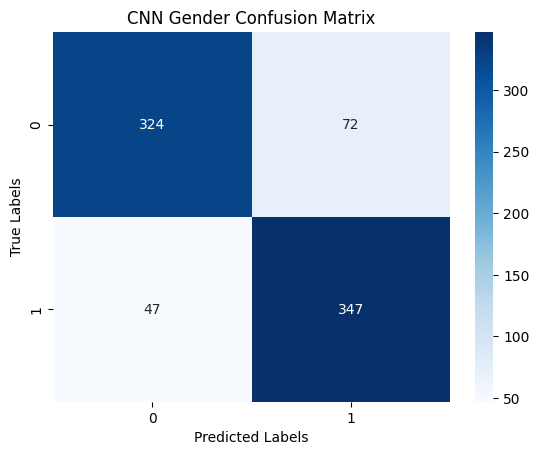

In [56]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_gender = np.round(predict[1]).flatten()

cm = confusion_matrix(y_test[:,1], y_pred_gender)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("CNN Gender Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [57]:
def error_count(error):
  error1 = 0
  error2 = 0
  error3 = 0
  error4 = 0
  if error < 5:
    error1 = error1+1
  elif error <= 10:
    error2 = error2+1
  elif error <= 15:
    error3 = error3+1
  elif error > 15:
    error4 = error4+1
  return error1,error2,error3,error4

In [60]:
predicted_age_list = []
y_test_list = []
error1_total = 0
error2_total = 0
error3_total = 0
error4_total = 0

for i in range(len(x_test)):
    predicted_age = model.predict(np.expand_dims(x_test[i], axis=0))
    predicted_age = int(predicted_age[0])
    predicted_age_list.append(predicted_age)
    percent_dif =  (abs(predicted_age-int(y_test[i][0]))/ int(max_age)) * 100
    error_count(percent_dif)
    error1, error2, error3, error4 = error_count(percent_dif)
    error1_total += error1
    error2_total += error2
    error3_total += error3
    error4_total += error4


1/1 [==============================] - 0s 19ms/step


In [61]:
percentage_error1 = (error1_total/len(x_test))*100
percentage_error2 = (error2_total/len(x_test))*100
percentage_error3 = (error3_total/len(x_test))*100
percentage_error4 = (error4_total/len(x_test))*100
print("Percentage of file that have 0-5 % error : ", round(percentage_error1,2), " %")
print("Percentage of file that have 6-10 % error: ", round(percentage_error2,2), " %")
print("Percentage of file that have 11-15 % error:", round(percentage_error3,2), " %")
print("Percentage of file that have more than 15% error : ", round(percentage_error4,2), " %")

Percentage of file that have 0-5 % error :  22.91  %
Percentage of file that have 6-10 % error:  22.41  %
Percentage of file that have 11-15 % error: 21.01  %
Percentage of file that have more than 15% error :  33.67  %


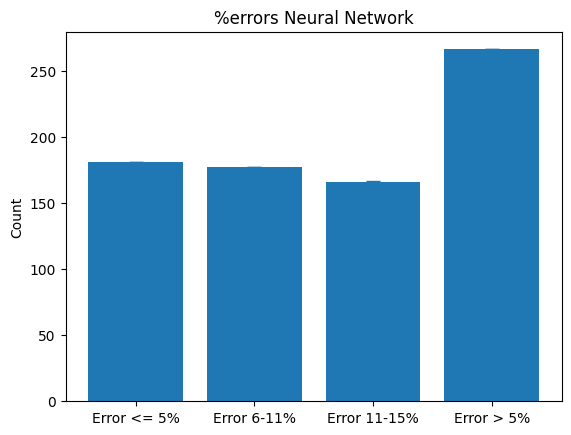

In [62]:
errors = [error1_total, error2_total, error3_total, error4_total]
plt.bar(x=[1,2,3,4], height=errors)
plt.errorbar(x=[1,2,3,4], y=errors, yerr=[0.1, 0.2, 0.15, 0.08], fmt='none', capsize=5)
plt.xticks([1,2,3,4], ['Error <= 5%', 'Error 6-11%', 'Error 11-15%', 'Error > 5%'])
plt.ylabel('Count')

plt.title('%errors Neural Network')
plt.show()


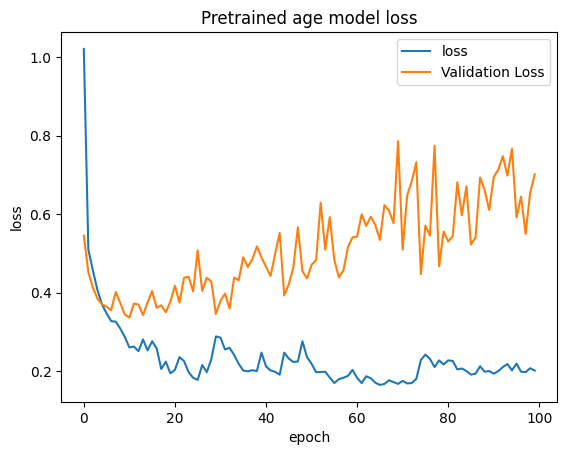

In [65]:
plt.plot(history_test.history['dense_24_loss'])
plt.plot(history_test.history['val_dense_24_loss'])
plt.title('Pretrained age model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

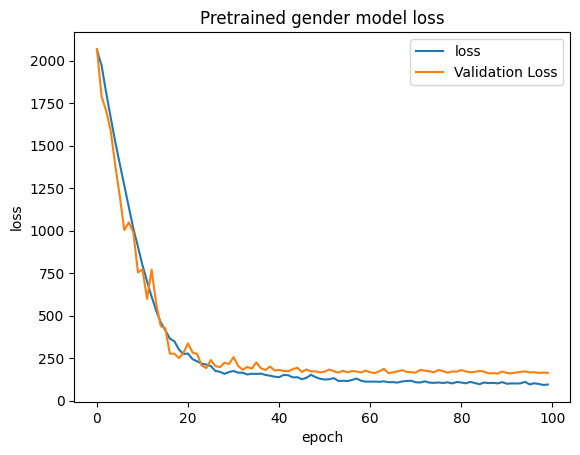

In [66]:
plt.plot(history_test.history['dense_21_loss'])
plt.plot(history_test.history['val_dense_21_loss'])
plt.title('Pretrained gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(["loss","Validation Loss"])
plt.show()

In [67]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/2in1/combine_test.h5')

# Make a prediction using the loaded model
prediction = loaded_model.predict(x_test)


In [ ]:
img = cv2.imread('/content/00000952.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 224x224
img_resized = cv2.resize(img, (224, 224))
img_resized = img_resized /255
# Reshape the image to (None, 224, 224, 1)
img_reshaped = img_resized.reshape((-1, 224, 224, 1))

# Print the shape of the reshaped image
print(img_reshaped.shape)


In [ ]:
prediction = loaded_model.predict(img_reshaped)

In [ ]:
prediction